In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import export_text
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from IPython.display import display

!pip install xgboost
%matplotlib inline


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [39]:
df = pd.read_csv("customer_churn_dataset-training-master.csv")
df_te = pd.read_csv("customer_churn_dataset-testing-master.csv")

In [40]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30,Female,39,14,5,18,Standard,Annual,932.0,17.0,1.0
1,3,65,Female,49,1,10,8,Basic,Monthly,557.0,6.0,1.0
2,4,55,Female,14,4,6,18,Basic,Quarterly,185.0,3.0,1.0
3,5,58,Male,38,21,7,7,Standard,Monthly,396.0,29.0,1.0
4,6,23,Male,32,20,5,8,Basic,Monthly,617.0,20.0,1.0


In [41]:
df.dtypes

CustomerID             int64
Age                    int64
Gender                object
Tenure                 int64
Usage Frequency        int64
Support Calls          int64
Payment Delay          int64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

In [42]:
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [43]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [44]:
df['total_spend'] = df['total_spend'].fillna(0)
df['last_interaction'] = df['last_interaction'].fillna(0)
df['churn'] = df['churn'].fillna(0)

In [45]:
df.head()

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2,30,Female,39,14,5,18,Standard,Annual,932.0,17.0,1.0
1,3,65,Female,49,1,10,8,Basic,Monthly,557.0,6.0,1.0
2,4,55,Female,14,4,6,18,Basic,Quarterly,185.0,3.0,1.0
3,5,58,Male,38,21,7,7,Standard,Monthly,396.0,29.0,1.0
4,6,23,Male,32,20,5,8,Basic,Monthly,617.0,20.0,1.0


In [46]:
df.isna().sum()

customerid           0
age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
last_interaction     0
churn                0
dtype: int64

In [47]:
df.describe().round()

,customerid,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,churn
count,20768.0,20768.0,20768.0,20768.0,20768.0,20768.0,20768.0,20768.0,20768.0
mean,10392.0,41.0,31.0,16.0,5.0,15.0,552.0,15.0,1.0
std,5995.0,14.0,17.0,9.0,3.0,9.0,259.0,9.0,0.0
min,2.0,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,5201.0,29.0,15.0,8.0,2.0,7.0,328.0,8.0,1.0
50%,10392.0,41.0,31.0,16.0,5.0,15.0,554.0,15.0,1.0
75%,15584.0,53.0,46.0,23.0,8.0,23.0,774.0,23.0,1.0
max,20776.0,65.0,60.0,30.0,10.0,30.0,1000.0,30.0,1.0


In [48]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=11)

In [49]:
len(df_train), len(df_val)

(16614, 4154)

In [50]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [51]:
y_train = (df_train.churn).astype('int').values
y_val = (df_val.churn).astype('int').values

In [52]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([ 194, 3960]))

In [53]:
del df_train['churn']
del df_val['churn']

In [54]:
df_train.head()

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,2289,40,Female,38,30,7,22,Standard,Quarterly,563.0,28.0
1,12800,27,Male,60,15,3,15,Premium,Quarterly,567.0,9.0
2,2561,65,Female,57,15,2,0,Basic,Annual,440.0,10.0
3,14554,57,Female,50,21,3,7,Premium,Annual,484.0,22.0
4,18855,51,Female,38,1,5,1,Standard,Quarterly,825.0,11.0


In [55]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [56]:
X_train

array([[ 40.,   0.,   0., ...,  38., 563.,  30.],
       [ 27.,   0.,   0., ...,  60., 567.,  15.],
       [ 65.,   1.,   0., ...,  57., 440.,  15.],
       ...,
       [ 32.,   0.,   0., ...,  33., 216.,   4.],
       [ 24.,   0.,   1., ...,  39., 559.,   7.],
       [ 63.,   0.,   0., ...,   7., 509.,  17.]], shape=(16614, 17))

In [57]:
features = dv.get_feature_names_out()
pd.Series(features).value_counts()

age                           1
contract_length=Annual        1
contract_length=Monthly       1
contract_length=Qu            1
contract_length=Quarterly     1
customerid                    1
gender=Female                 1
gender=Male                   1
last_interaction              1
payment_delay                 1
subscription_type=Basic       1
subscription_type=Premium     1
subscription_type=Standard    1
support_calls                 1
tenure                        1
total_spend                   1
usage_frequency               1
Name: count, dtype: int64

In [58]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [59]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9651059564719359

In [60]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.785
   2 -> 0.897
   3 -> 0.938
   4 -> 0.966
   5 -> 0.979
   6 -> 0.986
  10 -> 0.978
  15 -> 0.976
  20 -> 0.971
None -> 0.971


In [61]:
scoresd = []

for d in [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None]:
    for s in [1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scoresd.append((d, s, auc))

In [62]:
scores_d = pd.DataFrame(scoresd, columns=['max_depth', 'min_samples_leaf', 'auc'])
scores_d.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
213,40.0,20,0.993488
229,45.0,20,0.993488
245,50.0,20,0.993488
117,10.0,20,0.993471
261,NaN,20,0.993268
...,...,...,...
5,1.0,20,0.784691
3,1.0,10,0.784691
2,1.0,5,0.784691
1,1.0,2,0.784691


In [63]:
df_scoresd_pivot = scores_d.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])
df_scoresd_pivot.round(3)

auc                                                   \
max_depth           NaN   1.0    2.0    3.0    4.0    5.0    6.0    7.0    
min_samples_leaf                                                           
1                 0.973  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
2                 0.975  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
5                 0.981  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
10                0.983  0.785  0.897  0.938  0.966  0.979  0.986  0.980   
15                0.993  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
20                0.993  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
30                0.993  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
40                0.992  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
50                0.992  0.785  0.897  0.938  0.966  0.979  0.986  0.990   
60                0.991  0.785  0.897  0.938  0.966  0.979  0.986  0.989   
70                0.991  0.785  0.897  0.938  0.966  0.979  0.986  0.989   
80                0.991  0.785  0.897  0.938  0.966  0.979  0.985  0.989   
90                0.991  0.785  0.897  0.938  0.966  0.979  0.985  0.989   
100               0.990  0.785  0.897  0.938  0.966  0.979  0.985  0.989   
200               0.989  0.785  0.897  0.938  0.966  0.978  0.984  0.989   
500               0.983  0.785  0.897  0.938  0.964  0.977  0.983  0.983   

                                                                          \
max_depth          10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0   
min_samples_leaf                                                           
1                 0.978  0.976  0.976  0.968  0.973  0.968  0.973  0.973   
2                 0.978  0.970  0.971  0.970  0.973  0.975  0.973  0.973   
5                 0.985  0.986  0.986  0.986  0.986  0.986  0.986  0.986   
10                0.984  0.983  0.983  0.983  0.983  0.983  0.983  0.983   
15                0.993  0.993  0.993  0.993  0.993  0.993  0.993  0.993   
20                0.993  0.993  0.993  0.993  0.993  0.993  0.993  0.993   
30                0.993  0.993  0.993  0.993  0.993  0.993  0.993  0.993   
40                0.992  0.992  0.992  0.992  0.992  0.992  0.992  0.992   
50                0.992  0.992  0.992  0.992  0.992  0.992  0.992  0.992   
60                0.991  0.991  0.991  0.991  0.991  0.991  0.991  0.991   
70                0.991  0.991  0.991  0.991  0.991  0.991  0.991  0.991   
80                0.991  0.991  0.991  0.991  0.991  0.991  0.991  0.991   
90                0.991  0.991  0.990  0.991  0.991  0.990  0.990  0.991   
100               0.990  0.990  0.990  0.990  0.990  0.990  0.990  0.990   
200               0.989  0.989  0.989  0.989  0.989  0.989  0.989  0.989   
500               0.983  0.983  0.983  0.983  0.983  0.983  0.983  0.983   

                         
max_depth          50.0  
min_samples_leaf         
1                 0.973  
2                 0.973  
5                 0.986  
10                0.983  
15                0.993  
20                0.993  
30                0.993  
40                0.992  
50                0.992  
60                0.991  
70                0.991  
80                0.991  
90                0.990  
100               0.990  
200               0.989  
500               0.983

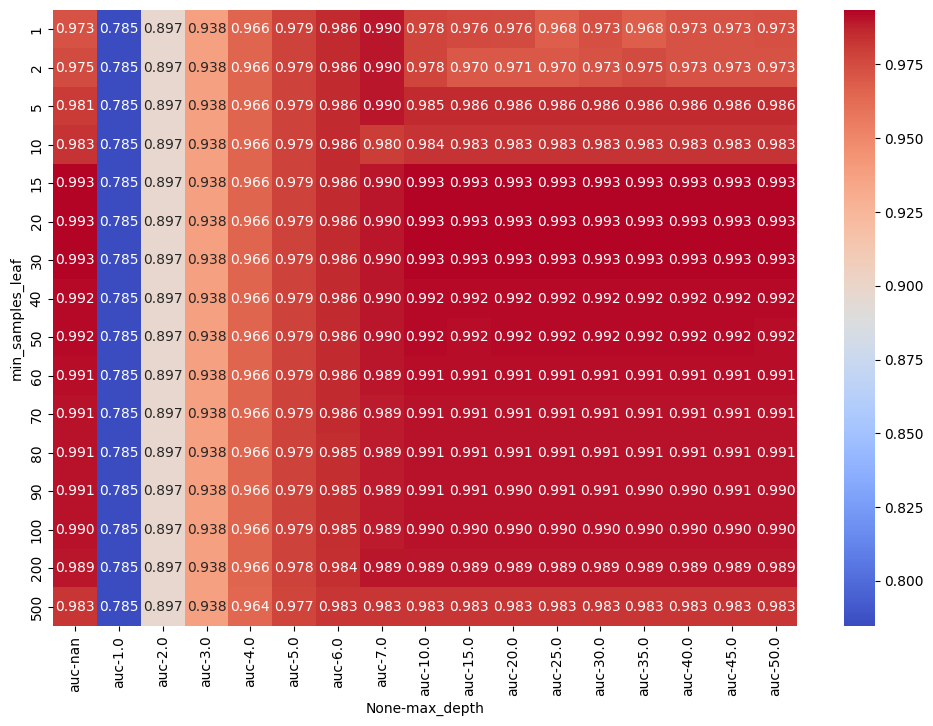

In [64]:
plt.figure(figsize=(12, 8))  
sns.heatmap(df_scoresd_pivot, annot=True, fmt='.3f', cmap='coolwarm')  
plt.show()

In [65]:
best_score = df_scoresd_pivot.max().max()
best_leaf, best_depth = np.where(df_scoresd_pivot == best_score)

In [66]:
best_min_leaf = df_scoresd_pivot.index[best_leaf[0]]
best_max_depth = df_scoresd_pivot.columns[best_depth[0]]

In [67]:
print(f"✅ Best score: {best_score}")
print(f"🌿 Best min_samples_leaf: {best_min_leaf}")
print(f"🌳 Best max_depth: {best_max_depth}")

✅ Best score: 0.9934877121732791
🌿 Best min_samples_leaf: 20
🌳 Best max_depth: ('auc', np.float64(40.0))


In [68]:
#final tuning max_depth = 25 and min_samples_leaf = 20
dt = DecisionTreeClassifier(max_depth=25, min_samples_leaf=20)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,25
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [69]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9934877121732791

In [70]:
scorerf = []
for n in range(10, 301, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scorerf.append((n, auc))

In [71]:
scoress_rf = pd.DataFrame(scorerf, columns=['n_estimator', 'auc'])
scoress_rf.sort_values(by='auc', ascending=False)

,n_estimator,auc
28,290,0.998523
26,270,0.998523
29,300,0.998523
25,260,0.998521
24,250,0.998513
17,180,0.998509
27,280,0.998508
21,220,0.998508
23,240,0.998504
16,170,0.998501


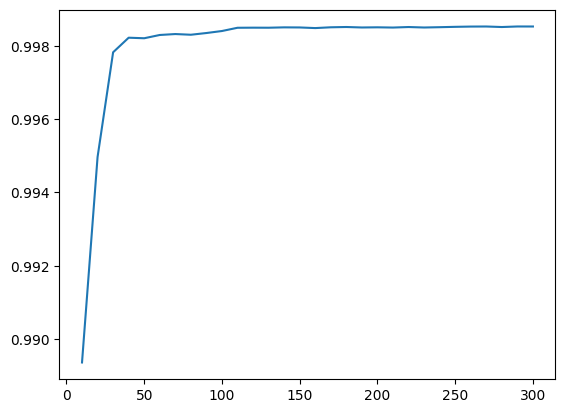

In [72]:
plt.plot(scoress_rf.n_estimator, scoress_rf.auc)

In [73]:
scorerfd = []

for d in [10, 15, 20, 25, 30, 35, 40]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scorerfd.append((n, d, auc))

In [76]:
scored_rdf = pd.DataFrame(scorerfd, columns=['n_estimator', 'max_depth', 'auc'])

In [77]:
scored_rdf.sort_values(by='auc')

,n_estimator,max_depth,auc
120,10,30,0.989368
90,10,25,0.989368
180,10,40,0.989368
150,10,35,0.989368
60,10,20,0.989475
...,...,...,...
72,130,20,0.998541
89,300,20,0.998544
88,290,20,0.998547
86,270,20,0.998560


In [78]:
rf = RandomForestClassifier(n_estimators=290, max_depth=10, min_samples_leaf=20, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,290
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
